In [4]:
# Import Tensorflow 2.0
import tensorflow as tf

In [5]:
#Install some dependencies for visualizing the agents
#!apt-get install -y xvfb python-opengl x11-utils &> /dev/null
#!pip install gym pyvirtualdisplay scikit-video ffio pyrender &> /dev/null
#!pip install tensorflow_probability==0.12.0 &> /dev/null
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import numpy as np
import matplotlib, cv2
import matplotlib.pyplot as plt
import base64, io, os, time, gym
import IPython, functools
import time
from tqdm import tqdm
#import tensorflow_probability as tfp

import mitdeeplearning as mdl

In [6]:
### Instantiate the Cartpole environment ###
## use seed() to ensure the environment's random variables are initialized the same each time
env = gym.make("CartPole-v1")
env.action_space.seed(1)
env.observation_space.seed(1)

[1]

In [7]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [8]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


In [9]:
### Define the Cartpole agent ###
# A deep neural network defines the agent. 
# Defines a feed-forward neural network
def create_cartpole_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=n_actions, activation=None)
    ])
    return model
cartpole_model = create_cartpole_model()

In [10]:
### Define the agent's action function ###

def choose_action(model, observation, single=True):
    # Extract the observation array from the tuple
    observation_array = observation[0] if isinstance(observation, tuple) else observation

    # Print out the extracted observation array for debugging
    print(f"Extracted observation array: {observation_array}")

    # Ensure the observation is a NumPy array
    observation_array = np.asarray(observation_array, dtype=np.float32)

    # Check if the observation is already a flat array
    if observation_array.ndim > 1:
        # Flatten the observation if it's not already a 1D array
        observation_array = observation_array.flatten()

    if single:
        observation_array = np.expand_dims(observation_array, axis=0)

    # Feed the observations through the model to predict the log probabilities of each possible action
    logits = model.predict(observation_array)

    # Choose an action from the categorical distribution defined by the log
    # probabilities of each possible action
    action = tf.random.categorical(logits, num_samples=1)

    action = action.numpy().flatten()

    return action[0] if single else action

In [11]:
### Agent Memory ###

class Memory:
    def __init__(self):
        self.clear()

  # Resets/restarts the memory buffer
    def clear(self):
        self.observations = []
        self.actions = []
        self.rewards = []

  # Add observations, actions, rewards to memory
    def add_to_memory(self, new_observation, new_action, new_reward):
        self.observations.append(new_observation)

        # update the list of actions with new action'''
        self.actions.append(new_action)

        # update the list of rewards with new reward'''
        self.rewards.append(new_reward)

    def __len__(self):
        return len(self.actions)

# Instantiate a single Memory buffer
memory = Memory()

In [ ]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
    # This centers the data around 0, so the mean of x is 0
    x -= np.mean(x)
    # Ensure that the std is always 1
    x /= np.std(x)
    return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95):
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R

    return normalize(discounted_rewards)

In [ ]:
### Loss function ###

# Arguments:
#   logits: network's predictions for actions to take
#   actions: the actions the agent took in an episode
#   rewards: the rewards the agent received in an episode
# Returns:
#   loss
def compute_loss(logits, actions, rewards):
    # complete the function call to compute the negative log probabilities
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=actions)

    # scale the negative log probability by the rewards
    loss = tf.reduce_mean(neg_logprob * rewards)
    return loss

In [ ]:
### Training step (forward and backpropagation) ###

def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards, custom_fwd_fn=None):
    with tf.GradientTape() as tape:
        # Forward propagate through the agent network
        if custom_fwd_fn is not None:
            prediction = custom_fwd_fn(observations)
        else:
            prediction = model(observations)

        # call the compute_loss function to compute the loss'''
        loss = loss_function(prediction, actions, discounted_rewards)

    '''TODO: run backpropagation to minimize the loss using the tape.gradient method.
             Unlike supervised learning, RL is *extremely* noisy, so you will benefit
             from additionally clipping your gradients to avoid falling into
             dangerous local minima. After computing your gradients try also clipping
             by a global normalizer. Try different clipping values, usually clipping
             between 0.5 and 5 provides reasonable results. '''
    grads = tape.gradient(loss, model.trainable_variables)

    grads, _ = tf.clip_by_global_norm(grads, 1)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [ ]:
## Training parameters ##
## Re-run this cell to restart training from scratch ##

# TODO: Learning rate and optimizer
learning_rate = 5e-3

optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.95)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

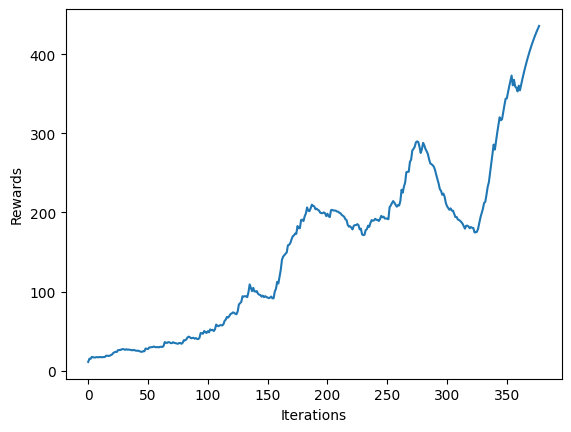

Extracted observation array: [-0.00335903 -0.02577931  0.049447   -0.01036304]
1/1 [==============================] - 0s 21ms/step
Result of env.step(action): (array([-0.00387462, -0.22157425,  0.04923974,  0.2975019 ], dtype=float32), 1.0, False, {})
Extracted observation array: [-0.00387462 -0.22157425  0.04923974  0.2975019 ]
1/1 [==============================] - 0s 22ms/step
Result of env.step(action): (array([-0.0083061 , -0.02718752,  0.05518978,  0.02074585], dtype=float32), 1.0, False, {})
Extracted observation array: [-0.0083061  -0.02718752  0.05518978  0.02074585]
1/1 [==============================] - 0s 21ms/step
Result of env.step(action): (array([-0.00884985, -0.22305574,  0.0556047 ,  0.3303184 ], dtype=float32), 1.0, False, {})
Extracted observation array: [-0.00884985 -0.22305574  0.0556047   0.3303184 ]
1/1 [==============================] - 0s 21ms/step
Result of env.step(action): (array([-0.01331097, -0.02876759,  0.06221107,  0.05567596], dtype=float32), 1.0, Fal

KeyboardInterrupt: 

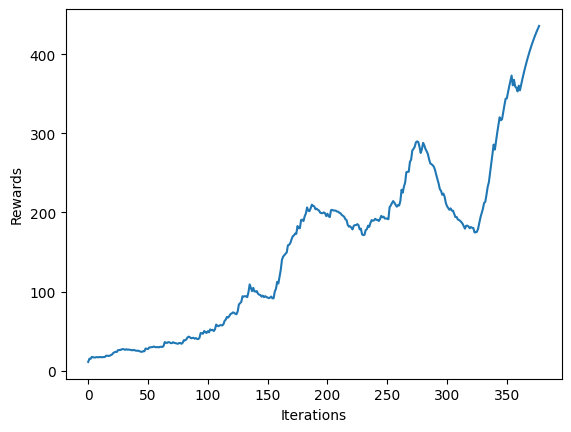

In [ ]:
## Cartpole training! ##
## Note: stoping and restarting this cell will pick up training where you
#        left off. To restart training you need to rerun the cell above as
#        well (to re-initialize the model and optimizer)

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(500):

    plotter.plot(smoothed_reward.get())
    
    # Restart the environment
    observation = env.reset()
    memory.clear()

    while True:
        # using our observation, choose an action and take it in the environment
        action = choose_action(cartpole_model, observation)
        result = env.step(action)
        print(f"Result of env.step(action): {result}")

        # Handle the returned values
        next_observation, reward, done, info = result
        # add to memory
        memory.add_to_memory(observation, action, reward)

        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)

            # initiate training - remember we don't know anything about how the
            #   agent is doing until it has crashed!

            try:
            # Perform training step
                g = train_step(cartpole_model, compute_loss, optimizer,
                                observations=np.vstack(memory.observations),
                                actions=np.array(memory.actions),
                                discounted_rewards=discount_rewards(memory.rewards))
            except ValueError as e:
                print(f"ValueError during training: {e}")

            # reset the memory
            memory.clear()
            break
        # update our observatons
        observation = next_observation

In [ ]:
matplotlib.use('Agg')
!apt-get update
!apt-get install -y xvfb
saved_cartpole = mdl.lab3_old.save_video_of_model(cartpole_model, "CartPole-v1")
mdl.lab3_old.play_video(saved_cartpole)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/skvideo/io/abstract.py:514: DeprecationWarning: tostring() is deprecated. Use toby

Successfully saved 500 frames into CartPole-v1.mp4!
